<a href="https://colab.research.google.com/github/sid521/ML8-ImageCaptioning/blob/main/final_imgcap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import tensorflow as tf
import cv2
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate, ReLU, LeakyReLU, Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections
import random
import time
#from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist
import matplotlib.image as mpimg
import json
from PIL import Image
#from transformers import T5ForConditionalGeneration, T5Tokenizer

In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


In [ ]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

TF_FORCE_GPU_ALLOW_GROWTH=1

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Download the coco dataset of images and their captions files
MSCOCO captions dataset consists of 83,000 images with each image having 5 captions .Approximately 13GB

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip) #remove zip file

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)# remove zip file
else:
    PATH = os.path.abspath('.') + image_folder

## limiting  the size of the training set for faster training
In this case limiting the number of images to 15000 with each image containing 5 captions resulting in 30000 captions 

## Preprocessing the captions

In [ ]:
#open the annotations(captions) .json file
annotation_file = os.path.abspath('.')+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>" 
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [ ]:
# shuffling the images
import random
image_paths = list(image_path_to_caption.keys())
random.Random(0).shuffle(image_paths)

# Select the first 15000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 75,000 examples.

In [ ]:
train_image_paths = image_paths[:15000]
print(len(train_image_paths))

In [ ]:
# form lists with captions and their respective image
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

### Initialising resnet50 model for feature extraction

Uncomment this code and excecute this if the Resnet model is already saved in your local disk and skip the resnet50 model building and move to preprocessing 

In [ ]:
# image_features_extract_model = load_model('/content/resnet50_model.hdf5')
# image_features_extract_model.summary()

### Identity block

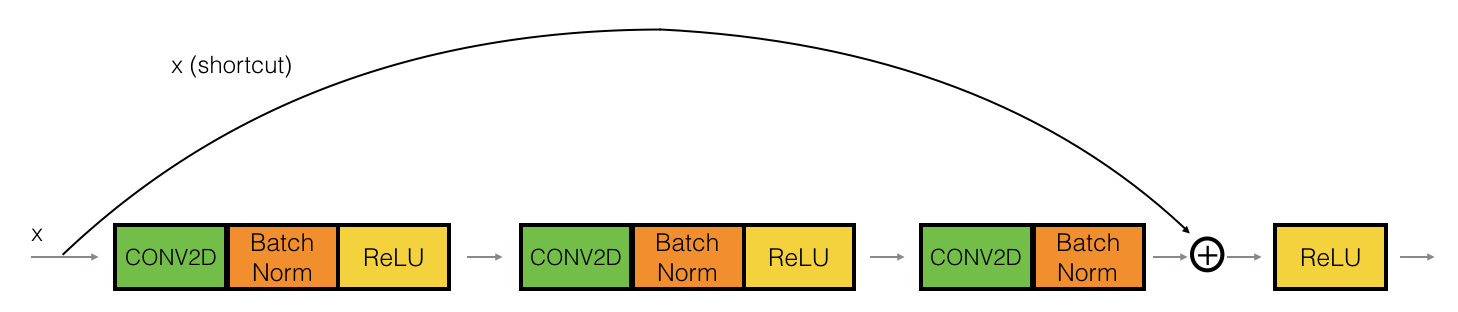

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of identity block as of above figure
    skips over two convolution block.
    Args:
    X -- input tensor
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block a tensor 
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X

### Convolutional Block

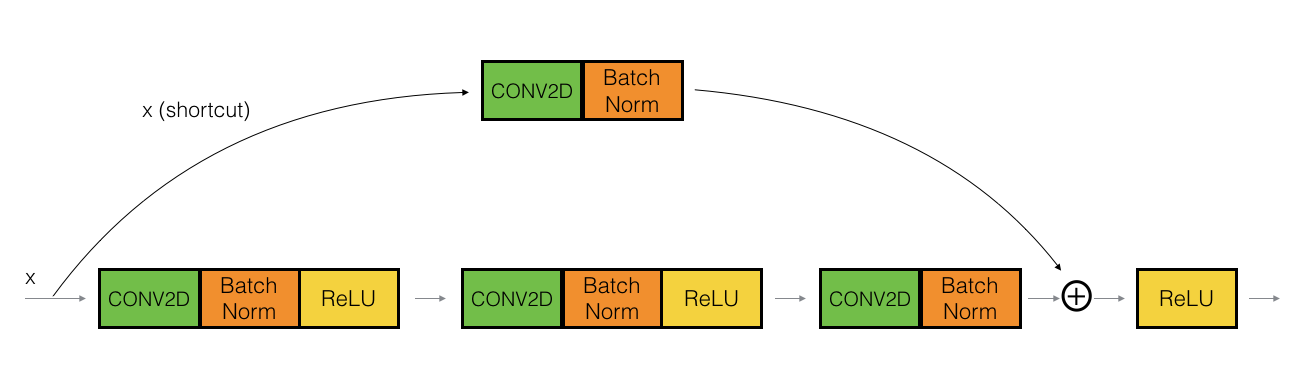

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure
    
    Arguments:
    X -- input tensor 
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block a tensor 
    """
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X

In [ ]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

## ResNet

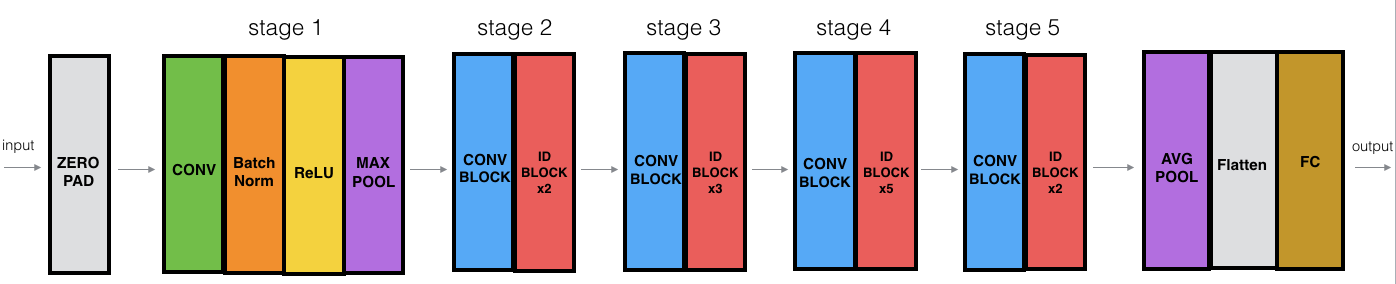

In [ ]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
def ResNet50(input_shape = (224, 224, 3)):

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    weights_path = utils.get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
    model.load_weights(weights_path,by_name=True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',top_5_accuracy])
    return model

In [ ]:
image_features_extract_model = ResNet50(input_shape = (224, 224, 3)) #output_shape=(7,7,2048)

Saving resnet50 model for direct predictions in future cases

In [ ]:
#saving the model in .hdf5 file
#choose your path
model_path ='weights/resnet50.hdf5'
image_features_extract_model.save_weights(model_path)

# Image preprocessing

preprocessing the training images and saving the output features to the disk . keeping them all in the memory will consume a lot of RAM which is not recommended. Saving them to disk as .npy files and lazy loading them using tf.data.Dataset when required is a better way to save memory

In [ ]:
#preprocess the image before feeding in to the model
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224)) # (224,224) is the default input of resnet50
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, image_path

skip the below code if you already dumped the numpy features to your disk

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

#batch size=16
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* Tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data
* limiting the vocabulary size to the top 5,000 words (to save memory). Replace all other words with the token "UNK" (unknown).
* Create word-to-index and index-to-word mappings.
* Finally, pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

Uncomment the below cell and execute if you already saved the tokeniser to the disk and skip to create tokenized words

In [ ]:
# #load word tokenizer
# with open('/content/tokenizer.json') as f:
#     data = json.load(f)
#     tokenizer = tokenizer_from_json(data)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

Saving the tokenizer to directly load it for prediction

In [ ]:
import io
tokenizer_json = tokenizer.to_json()
with io.open('weights/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(max_length)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training, validation, test sets using an 95-4-1 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.95)
slice_index_1 = int(len(img_keys)*0.99)
img_name_train_keys, img_name_val_keys,img_name_test_keys = img_keys[:slice_index], img_keys[slice_index:slice_index_1],img_keys[slice_index_1:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

img_name_test = []
cap_test = []
for imgtest in img_name_test_keys:
  captest_len = len(img_to_cap_vector[imgtest])
  img_name_test.extend([imgtest] * captest_len)
  cap_test.extend(img_to_cap_vector[imgtest])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val),len(cap_test),len(img_name_test)

## Create a tf.data dataset for training


images and captions are ready.creating a `tf.data` dataset to use for training the model.

In [ ]:
# Choose optimal parameters depending upon system configuration
# Can be changed depending upon your system configuration
top_k = 5000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from resnet50 is (49, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

*  extract the features from the lower convolutional layer of Resnet50 giving us a vector of shape (7, 7, 2048).
* squashing that to a shape of (49, 2048).
* This vector is then passed through the CNN Encoder
* The RNN attends over the image to predict the next word.

### Attention model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 49, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 49, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 49, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 49, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

###  CNN Encoder Model

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # This encoder passes those features extracted from resnet50 (49,2048)through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc1 = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc1(x)
        x = tf.nn.relu(x)
        return x

### RNN Decoder Model

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(self.units)
    self.fc3 = tf.keras.layers.Dense(vocab_size)
    self.drop = tf.keras.layers.Dropout(0.25)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    x= self.drop(x)

    # passing the concatenated vector to the stack of GRU layers
    output, state = self.gru1(x)
    x = self.drop(output)
    output, state_ = self.gru2(x)
    x = self.drop(output)
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(x)
    x= self.drop(x)
    x = self.fc2(x)
    x= self.drop(x)
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    # output shape == (batch_size * max_length, vocab)
    x = self.fc3(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# creating instances of the model
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

Uncomment and run the below cell to directly load the pretrained weights to the encoder and decoder to skip the training and check the validation. Skip the training section or retrain the model 

In [ ]:
# # calling model and load the pretrained weights to decoder and encoder to skip the training and check the validation and test
# inp = tf.expand_dims([tokenizer.word_index['<start>']], 0)
# vocab_size=5001
# encoder(np.zeros((49,2048)))
# encoder.built=True
# hidden = decoder.reset_state(batch_size=1)
# decoder(inp,np.zeros((49,256)),hidden)
# decoder.built=True

# #weights path
# encoder_path='/content/encoder_gru_stack_2_512_enc_total.h5'
# decoder_path='/content/decoder_gru_stack_2_512_enc_total.h5'

# encoder.load_weights(encoder_path)
# decoder.load_weights(decoder_path)

In [ ]:
#loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoint_gru2_encode_1/train_2"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] *
                               target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    #   print(trainable_variables)

    gradients = tape.gradient(loss, trainable_variables)
    #   print('here')

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    #   print('this')
    return loss, total_loss

### Training

In [ ]:
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    i=0
    for (batch, (img_tensor, target)) in enumerate(dataset):
#         i=i+1
#         print(i)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
# saving the encoder and decoder model weights
encoder_path='final_weights/encoder_gru_stack_2_512_enc_1.h5'
decoder_path='final_weights/decoder_gru_stack_2_512_enc_1.h5'
encoder.save_weights(encoder_path)
decoder.save_weights(decoder_path)

In [ ]:
#loss plot
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption Prediction

### Greedy search algorithm

In [ ]:
# greedy search algoritm for caption generation/prediction and attention plot
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions, 1)[0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

### Beam search algorithm


In [ ]:
# beam search algoritm for caption prediction
def beam_search_predictions(image, beam_index=2):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    start = [tokenizer.word_index["<start>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            dec_input = tf.expand_dims([s[0][-1]],1)
            preds, hidden, attention_weights = decoder(
                dec_input, features, hidden)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Attention plot for visualisation

In [ ]:
# function to plot attention using attention weights
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (7, 7))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## captions on the validation set

In [ ]:
# predicted caption on a random image from the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
img_ = mpimg.imread(image)
plt.imshow(img_)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Accuracy metric

creating a psuedo metric for accuracy . the cosine simlarity of the predicted and actual captions is greater than than the threshold value (0.9) cosidered as correct (which is absolutly not) but for the sake of understanding the model performance


In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
# similarity threshold 
threshold = 0.9
# psudeo accuracy calculation for random 100 images in validation set
correct=0
real_captions=[]
for ind in range(len(img_name_val[:100])):
    img = img_name_val[ind]
    captions = img_to_cap_vector[img]
    for cap in captions:
        temp = ' '.join([tokenizer.index_word[i] for i in cap if i not in [0]])
        temp = temp.replace('<start>', ' ')
        temp = temp.replace('<end>', ' ')
        real_captions.append(temp)
    result, attention_plot = evaluate(img)
    res = ' '.join(result)
    result = res.replace('<end>', ' ')
    encodings = model.encode(real_captions)
    result_encoding = model.encode(result)
    sim_mat = 1 - (cdist(encodings, [result_encoding], 'cosine'))
    max_index = np.argmax(sim_mat)
    similarity = sim_mat[max_index]
    if similarity > threshold:
        correct = correct+1
    if (ind+1)%10 == 0:
        print('Accuracy of {} images is {} %'.format(ind+1,(correct/(ind+1))*100))
accuracy = (correct/len(img_name_val[:100]))*100
print("Accuracy of validation images : {} %".format(accuracy)) 

# Captions on test images

In [ ]:
# the cosine similarity of a random image in the test dataset
def similarity_score(index=None, verbose=True, view_image=False):
    """ index : the index of the test image in the img_name_test list.
                if none select a random image
        verbose: show text 
        view_image: display the the image"""
    real_captions = []
    if index == None or index >= len(img_name_test):
        rid = np.random.randint(0, len(img_name_test))
    else:
        rid = index
    image = img_name_test[rid]
    a = img_to_cap_vector[image]
    for cap in a:
        temp = ' '.join([tokenizer.index_word[i] for i in cap if i not in [0]])
        temp = temp.replace('<start>', ' ')
        temp = temp.replace('<end>', ' ')
        real_captions.append(temp)
    result, attention_plot = evaluate(image)
    res = ' '.join(result)
    result = res.replace('<end>', ' ')
    encodings = model.encode(real_captions)
    result_encoding = model.encode(result)
    sim_mat = 1 - (cdist(encodings, [result_encoding], 'cosine'))
    max_index = np.argmax(sim_mat)
    similarity = sim_mat[max_index]

    if verbose:
        print(
            'maximm cosine similarity from the 5 true captions and the predicted caption : ',
            similarity)
        print("true caption : ", real_captions[max_index])
        print('Prediction Caption:', result)
        if view_image:
            img = mpimg.imread(image)
            imgplot = plt.imshow(img)
    return similarity

In [ ]:
similarity_score(20,view_image=True)

In [ ]:
# cosine similarity of n random test images and their mean
def mean_similarity_n_images(n=10):
  similarities=[]
  randomlist = random.sample(range(0, len(img_name_test)), n)
  for i in randomlist:
    similarity = similarity_score(verbose=False)
    similarities.append(similarity)
  mean_similarity =sum( similarities)/len(similarities)
  print('mean cosine similarity of {} random images : '.format(n),mean_similarity)
  return similarities , mean_similarity

In [ ]:
b = mean_similarity_n_images()

In [ ]:
# predict a image from your local directory
def greedy_predict(path):
    filename = os.path.abspath(path)
    img = Image.open(path)
    result, attention_plot = evaluate(path)
    res = ' '.join(result)
    result = res.replace('<end>',' ')
    print('Prediction Caption:', result)
    img_ = mpimg.imread(filename)
    plt.imshow(img_)

In [ ]:
path = 'example.jpg'
greedy_predict(path)

# Video Summariser

## Converting Video into frames

In [ ]:
import cv2
list=[]
# Opens the Video file
cap= cv2.VideoCapture('/content/samplevideo.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        total= i
        # 'total number of frames-1'  for the video
        print(total)
        break
    file_name_path = '/content/frames/frame' + str(i) + '.jpg' 
    list.append(file_name_path)   
    cv2.imwrite(file_name_path,frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

In [ ]:
i=0
predics=[]
# empty list to append the predicted captions for all the frames
while i<total:
  image = list[i]
  result, attention_plot = evaluate(image)
  res = ' '.join(result)
  result = res.replace('<end>',' ')
  predics.append(result)
  #list where captions associated to all frames of video are stored 
  i=i+60
  #taking 1 frame out of every 60 frames
  #considering 1 frame for every 2 seconds

In [ ]:
#Remove one of the consecutive image caption greater than certain cosine similarity threshold between the two captions
# threshold value is 0.50
import math
i=0
n=math.floor((total/60)+1)
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
while i<n-1:
  sentences=[]
  sentences.append(predics[i])
  if len(predics)>=i+1:
    break
  else:  
    sentences.append(predics[i+1])
  model=SentenceTransformer('bert-base-nli-mean-tokens')
  sentence_embeddings=model.encode(sentences)
  #sentence_embeddings.shape
  cs=cosine_similarity([sentence_embeddings[0]],sentence_embeddings[1])
  if cs>0.50:
    del predics[i]
  else:
    i=i+1  


In [ ]:
#number of sentences removed by threshold
print(n-len(predics))

#Summarizing the Text using T5 base Transformer

In [ ]:
Text=" "
Text=Text+predics[0]
#concat all sentences in list and convert it into one paragraph
for i in range(1,int(n)):
  Text=Text+"."+predics[i]

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
# initialize the model architecture and weights
model = T5ForConditionalGeneration.from_pretrained("t5-large")
# initialize the model tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-large")

In [ ]:
#encode the text into tensor of integers using the appropriate tokenizer
inputs = t5_tokenizer.encode("summarize: " + Text, return_tensors="pt",truncation=True)

In [ ]:
# summary output generation in form of tokens
outputs = model.generate(
    inputs, 
    max_length=512, 
    min_length=50, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)
print(outputs)

In [ ]:
#Final Summarized output
print(t5_tokenizer.decode(outputs[0]))